In [1]:
import pandas as pd
import numpy as np 
import imblearn as ibl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from utils import selecionar_melhor_k_knn, do_cv_knn

# Valores Faltantes e Atributos Categóricos

## Atributos Categóricos

Algumas bases de dados contém atributos categóricos. Os valores destes atributos não assumem valores numéricos.  Exemplos de atributos categóricos incluem: "genero" que pode assumir os valores "masculino", "feminino" ou "outros"; "cargo" que pode assumir os valores "executivo", "gerente" ou "técnico"; entre outros. Como os valores não são numéricos é impossível representar *diretamente* instâncias que contém atributos categóricos em um espaço euclidiano de características ($\mathbb{R}^n$). Como consequência, não é possível usar métodos de classificação que operam no espaço euclidiano (como o KNN) em bases de dados com atributos categóricos. Nesta aula vamos aprender algumas formas de transformar atributos categóricos em atributos numéricos, possibilitando a construção de modelos que operam no espaço euclidiano.

Nesta aula vamos usar um subconjunto dos atributos da base de dados *employee*. As instâncias dessa base de dados representam vários empregados de uma empresa. Os atributos de entrada descrevem alguns dados coletados sobre os empregados, como avaliações, horas trabalhadas e informações sobre promoções, acidentes de trabalho, departamento e faixa salarial. O atributo de saída (*left*) indica se o empregado deixou a empresa. Estamos deixando alguns atributos de fora para dificultar um pouco o problema de classificação.

In [2]:
df = pd.read_csv('employee.csv')
#deixar apenas as 4 ultimas colunas (3 atributos de entrada + 1 de saída)
df.drop(df.columns[:-4:1], axis=1, inplace=True)
#converter y para numpy array 1d
y = df[['left']].values.ravel()
X = df.drop('left', axis=1)
df

,promotion_last_5years,department,salary,left
0,0,sales,low,1
1,0,sales,medium,1
2,0,sales,medium,1
3,0,sales,low,1
4,0,sales,low,1
...,...,...,...,...
14994,0,support,low,1
14995,0,support,low,1
14996,0,support,low,1
14997,0,support,low,1


### Codificação Ordinal

O mapeamento dos valores de atributos categóricos em valores numéricos é denominado **codificação**. A forma mais simples de codificação é a *codificação ordinal*.  Neste esquema, cada valor recebe um código numérico inteiro que o representa. Por exemplo, vamos supor um atributo categórico "cor" que pode assumir os valores "vermelho", "verde", "azul" ou "roxo". Em uma codificação categórica, poderíamos associar cada valor com um código numérico: "vermelho" $\to$ 0, "verde" $\to$ 1, "azul" $\to$ 2 e "roxo" $\to$ 3. Assim, todas as instâncias que tiverem o valor "vermelho" para o atributo "cor" passsam a representá-lo como 0, as instâncias com "cor" = "verde" passam a representá-lo como 1, e assim por diante.

O ``sklearn`` oferece a classe ``OrdinalEncoder`` que faz essa codificação automaticamente.

In [3]:
#Vamos usar o ColumnTransformer para combinar vários encoders em um único "codificador"
#No exemplo inicial, vamos usar OrdinalEncoder para codificar 2 atributos. Entretanto,
#vários encoders diferenes podem ser usados em um único ColumnTransformer, como veremos adiante.
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

In [13]:
#A idéia é que o ColumnTransform é construído como uma lista de "transformers". No 
#sklearn as classes que tem os métodos "transfom", como OrdinalEncoder, PCA, StandardScaler, etc,
#são considerados transformers.

#Cada elemento da lista é uma tupla (nome, transformer, lista_de_colunas) que codifica quais colunas (do pandas dataframe)
#serão codificadas com aquele transformador. "nome" é usado em algumas outras operações que veremos mais adiante.
transformers = [
    ('oe_department', OrdinalEncoder(), ['department']),
    ('oe_salary', OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['salary']),
]

#construir o transformer de acordo com a lista de transformadores.
#O atributo remainder indica o que fazer com os atributos que não foram listados na lista de transformer.
#"passthrough" indica que esses atributos devem ser apenas copiados para a saída, sem alterações.
ct = ColumnTransformer(
    transformers, remainder='passthrough'
)
#Deduzir todos os códigos dos encoders e já fazer a codificação. É importante ressaltar que a saída é um numpy.ndarray,
#e não um pandas DataFrame.
X_oe = ct.fit_transform(X)
#Imprime as categorias do transformer 0. Note que como "IT" está na primeira posição, ele é o código 0,
#RandD é código 1, e assim por diante.
print(ct.transformers_[0][1].categories_)

[array(['IT', 'RandD', 'accounting', 'hr', 'management', 'marketing',
       'product_mng', 'sales', 'support', 'technical'], dtype=object)]


Note que fizemos a codificação dos atributos categóricos de todas as instâncias da base de dados em conjunto, sem a separação entre conjunto de treinamento e teste. Neste caso não é um problema, uma vez que apenas estamos convertendo a base de dados para uma versão equivalente, sem atributos categóricos. Entretanto, caso queira codificar mais dados, como no caso de usar o modelo em dados do mundo real, basta usar o método ``ct.transform``.

In [8]:
accs = do_cv_knn(X_oe, y, 10, range(1,20,2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.69, max: 0.76, avg +- std: 0.74+-0.02


Os atributos que possuem uma relação de ordem intrínseca, como é o caso do atributo *salary* acima, cujos valores "low", "medium" e "high" representam a ordem crescente de salários são bons candidatos a serem codificados por um codificador ordinal. Por isso, não é surpreendente que tais atributos sejam denominados *atributos ordinais*. Note que as categorias foram passadas explicitamente ao construtor: ``OrdinalEncoder(categories=[['low', 'medium', 'high']])``, indicando a ordem das categorias. Desta forma, "low" $\to$ 0, "medium" $\to$ 1 e "high" $\to$ 2.

Embora a codificação ordinal seja simples e fácil de entender, ela não é adequada para codificar qualquer tipo de atributo categórico. Isto porque alguns algoritmos de aprendizagem de máquina consideram que suas entradas são contínuas, e, por consequencia, considerariam que as categorias (valores do atributo categórico) como ordenadas. Isto não faz sentido para alguns atributos. Por exemplo, alguns algoritmos de aprendizagem de máquina poderiam considerar os valores do atributo *department* podem ter uma relação de ordem. Entretanto, esta relação não existe: queremos apenas diferenciar departamentos diferentes que os empregados podem estar vinculados. Atributos que não apresentam uma relação de ordem, como *department*, são chamados de *atributos nominais*, e normalmente usam outra codificação, como *One-Hot encoding*, que veremos a seguir. 

### One-Hot Encoding (dummy variable encoding)

Neste esquema de codificação, um atributo categórico com $n$ categorias é codificado em $n$ atributos binários, um deles com valor 1, que representa o valor do atributo para aquela instância, e os demais com valor 0. A Figura abaixo mostra um exemplo de codificação one-hot:

<div align='center'>
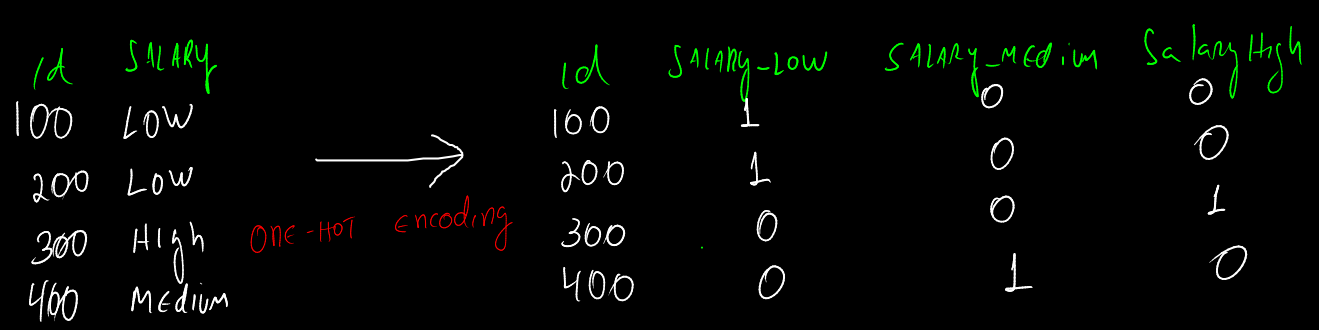
</div>

Note como a coluna *salary* foi codificada em três colunas, uma para cada categoria: *salary_low*, *salary_medium* e *salary_high*. Este esquema de codificação é adequado para atributos nominais, como o atributo *department* do exemplo.

O ``sklearn`` oferece a classe ``OneHotEncoder``  que implementa esta codificação.

In [14]:
from sklearn.preprocessing import OneHotEncoder

transformers = [
    ('oh_department', OneHotEncoder(), ['department']),
    ('oh_salary', OneHotEncoder(), ['salary']),
]

ct_oh = ColumnTransformer(
    transformers, remainder='passthrough'
)

#O sklearn detecta que esta codificação pode levar a uma matriz esparsa (com muitos zeros). Entretanto, em nosso modelo
#estamos supondo que a matriz é densa. O método todense da classe numpy.ndarray serve para obter a matriz de saída como
#uma matriz densa ao invés de uma matriz esparsa.
X_oh = ct_oh.fit_transform(X).todense()

In [16]:
ct_oh.get_feature_names(), X_oh.shape, X.shape

(['oh_department__x0_IT',
  'oh_department__x0_RandD',
  'oh_department__x0_accounting',
  'oh_department__x0_hr',
  'oh_department__x0_management',
  'oh_department__x0_marketing',
  'oh_department__x0_product_mng',
  'oh_department__x0_sales',
  'oh_department__x0_support',
  'oh_department__x0_technical',
  'oh_salary__x0_high',
  'oh_salary__x0_low',
  'oh_salary__x0_medium',
  'promotion_last_5years'],
 (14999, 14),
 (14999, 3))

Note os nomes dos atributos após a codificação one-hot. Veja que um atributo foi criado para cada categoria dos atributos *department* e *salary*. Com isto, a dimensionalidade do vetor de características passou de 3 pra 14. Por consequência, a validação cruzada demorará mais para executar:

In [17]:
accs = do_cv_knn(X_oh, y, 10, range(1,20,2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.73, max: 0.76, avg +- std: 0.75+-0.01


Note que o resultado obtido usando apenas codificação ordinal ($0.74 \pm 0.02$) foi muito semelhante ao resultado no qual codificamos os atributos usando apenas codificação one-hot ($0.75 \pm 0.01$). Na aula que vem iremos aprender como comparar modelos para descobrir se a diferença nos resultados é estatisticamente significativa.

A seguir vamos verificar o que acontece com essa base de dados, se usarmos encoders diferentes para cada atributo.

### Combinando *encoders* diferentes

Conforme foi discutido acima, é recomendado usar codificação one-hot para atributos nominais e codificação ordinal para atributos ordinais. Usando ``ColumnTransformer`` é bem simples aplicar codificadores diferentes em colunas diferentes.

In [20]:
#Note que agora estamos usando OneHotEncoder para codificar o departamento e 
# OrdinalEncoder para codificar as faixas salariais
transformers = [
    ('oh_department', OneHotEncoder(), ['department']),
    ('oe_salary', OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['salary']),
]

ct_ohoe = ColumnTransformer(
    transformers, remainder='passthrough'
)
X_ohoe = ct_ohoe.fit_transform(X).todense()

In [22]:
X_ohoe.shape, X.shape

((14999, 12), (14999, 3))

Desta vez o número de atributos passou de 3 para 12.

In [21]:
accs = do_cv_knn(X_ohoe, y, 10, range(1,20,2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.73, max: 0.76, avg +- std: 0.75+-0.01


Nesta base de dados o resultado obtido codificando os atributos categóricos com encoders apropriados não foi muito diferente dos resultados obtidos com as duas outras estratégias que avaliamos. Entretanto, isto nem sempre acontece. É importante avaliar diferentes combinações de técnicas de codificação de atributos categóricos para obter melhores resultados.

# Valores Faltantes

In [16]:
df = pd.read_csv('employee_nans.csv')
y = df[['left']].values.ravel()
X = df.drop('left', axis=1)
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,NaN,0.53,2.0,157.0,3.0,0.0,0.0,sales,low,1
1,0.80,0.86,5.0,262.0,6.0,0.0,0.0,sales,medium,1
2,0.11,0.88,7.0,272.0,4.0,0.0,0.0,sales,medium,1
3,0.72,0.87,5.0,223.0,5.0,0.0,0.0,sales,low,1
4,0.37,0.52,2.0,159.0,3.0,0.0,0.0,sales,low,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2.0,151.0,3.0,0.0,0.0,support,low,1
14995,0.37,NaN,2.0,160.0,3.0,0.0,0.0,support,low,1
14996,0.37,0.53,2.0,143.0,3.0,0.0,0.0,support,low,1
14997,0.11,0.96,6.0,280.0,4.0,0.0,0.0,support,low,1


In [17]:
df.isnull().sum().sum()

6736

### Exclusão das instâncias com atributos faltantes

In [18]:
df.dropna(inplace=True)

y = df[['left']].values.ravel()
X = df.drop('left', axis=1)
df.isnull().sum().sum()

0

In [19]:
transformers = [
    ('oh_department', OneHotEncoder(), ['department']),
    ('oe_salary', OrdinalEncoder(), ['salary']),
]

ct_ohoe = ColumnTransformer(
    transformers, remainder='passthrough'
)
X_ohoe = ct_ohoe.fit_transform(X)
accs = do_cv_knn(X_ohoe, y, 10, range(1,20,2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.95, max: 0.97, avg +- std: 0.96+-0.01


### Substituição de valores faltantes

In [21]:
df = pd.read_csv('employee_nans.csv')
y = df[['left']].values.ravel()
X = df.drop('left', axis=1)
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,NaN,0.53,2.0,157.0,3.0,0.0,0.0,sales,low,1
1,0.80,0.86,5.0,262.0,6.0,0.0,0.0,sales,medium,1
2,0.11,0.88,7.0,272.0,4.0,0.0,0.0,sales,medium,1
3,0.72,0.87,5.0,223.0,5.0,0.0,0.0,sales,low,1
4,0.37,0.52,2.0,159.0,3.0,0.0,0.0,sales,low,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2.0,151.0,3.0,0.0,0.0,support,low,1
14995,0.37,NaN,2.0,160.0,3.0,0.0,0.0,support,low,1
14996,0.37,0.53,2.0,143.0,3.0,0.0,0.0,support,low,1
14997,0.11,0.96,6.0,280.0,4.0,0.0,0.0,support,low,1


In [22]:
df.isnull().sum().sum()

6736

In [23]:
from sklearn.impute import SimpleImputer

In [24]:
atributos_numericos = ['satisfaction_level', 'last_evaluation', 'number_project', 
                              'average_montly_hours', 'time_spend_company', 'Work_accident', 
                              'promotion_last_5years']
transformers = [
    ('imp', SimpleImputer(strategy='mean'), atributos_numericos),
]


ct_si_num = ColumnTransformer(
    transformers, remainder='drop'
)
X_si_num = ct_si_num.fit_transform(X)

In [25]:
atributos_categoricos = ['department', 'salary']

transformers = [
    ('imp', SimpleImputer(strategy='constant', fill_value='unknown'), atributos_categoricos),
]

ct_si_cat = ColumnTransformer(
    transformers, remainder='drop'
)
X_si_cat = ct_si_cat.fit_transform(X)

In [26]:
X_imputed = pd.DataFrame(np.hstack((X_si_num, X_si_cat)), columns=[*atributos_numericos, *atributos_categoricos])

In [27]:
X_imputed

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary
0,0.612244,0.53,2.0,157.0,3.0,0.0,0.0,sales,low
1,0.8,0.86,5.0,262.0,6.0,0.0,0.0,sales,medium
2,0.11,0.88,7.0,272.0,4.0,0.0,0.0,sales,medium
3,0.72,0.87,5.0,223.0,5.0,0.0,0.0,sales,low
4,0.37,0.52,2.0,159.0,3.0,0.0,0.0,sales,low
...,...,...,...,...,...,...,...,...,...
14994,0.4,0.57,2.0,151.0,3.0,0.0,0.0,support,low
14995,0.37,0.716295,2.0,160.0,3.0,0.0,0.0,support,low
14996,0.37,0.53,2.0,143.0,3.0,0.0,0.0,support,low
14997,0.11,0.96,6.0,280.0,4.0,0.0,0.0,support,low


In [28]:
transformers = [
    ('oh_department', OneHotEncoder(), ['department']),
    ('oe_salary', OrdinalEncoder(), ['salary']),
]

ct_ohoe = ColumnTransformer(
    transformers, remainder='passthrough'
)
X_imputed_ohoe = ct_ohoe.fit_transform(X_imputed)

In [29]:
X_imputed_ohoe.shape

(14999, 19)

In [30]:
accs = do_cv_knn(X_imputed_ohoe, y, 10, range(1,20,2))

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.94, max: 0.95, avg +- std: 0.94+-0.00


## Valores Faltantes e Validação Cruzada


In [32]:
def imputar_dados(X_treino, X_teste):
    atributos_numericos = ['satisfaction_level', 'last_evaluation', 'number_project', 
                              'average_montly_hours', 'time_spend_company', 'Work_accident', 
                              'promotion_last_5years']
    atributos_categoricos = ['department', 'salary']
    
    transformers = [
        ('imp_num', SimpleImputer(strategy='mean'), atributos_numericos),
        ('imp_cat', SimpleImputer(strategy='constant', fill_value='unknown'), atributos_categoricos),
    ]
    
    ct = ColumnTransformer(
        transformers, remainder='drop'
    )
    X_imputed_treino = ct.fit_transform(X_treino)
    X_imputed_treino = pd.DataFrame(X_imputed_treino, columns=[*atributos_numericos, *atributos_categoricos])
    
    X_imputed_teste = ct.transform(X_teste)
    X_imputed_teste = pd.DataFrame(X_imputed_teste, columns=[*atributos_numericos, *atributos_categoricos])
    
    
    return X_imputed_treino, X_imputed_teste

def codificar_categoricas(X_treino, X_teste):
    
    transformers = [
        ('oh_department', OneHotEncoder(), ['department']),
        ('oe_salary', OrdinalEncoder(), ['salary']),
    ]

    ct = ColumnTransformer(
        transformers, remainder='passthrough'
    )
    X_treino_ = ct.fit_transform(X_treino)
    X_teste_ = ct.transform(X_teste)
    
    return X_treino_, X_teste_
    

In [33]:
def do_cv_knn_imputer(X, y, cv_splits, ks, imputer=None, encoder=None):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    acuracias = []
    fold = 1
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        if isinstance(X, pd.DataFrame):
            X_treino = X.iloc[treino_idx]
            X_teste = X.iloc[teste_idx]
            
            if imputer is not None:
                X_treino, X_teste = imputer(X_treino, X_teste)            

            if encoder is not None:
                X_treino, X_teste = encoder(X_treino, X_teste)    
            else:
                X_treino = X_treino.values
                X_teste = X_teste.values
                
        else:
            X_treino = X[treino_idx]
            X_teste = X[teste_idx]
            
        y_treino = y[treino_idx]
        y_teste = y[teste_idx]
        
        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        knn, _, _ = selecionar_melhor_k_knn(ks, X_treino, X_val, y_treino, y_val)
        pred = knn.predict(X_teste)

        acuracias.append(accuracy_score(y_teste, pred))
        
        fold+=1
        pgb.update(1)
    
    pgb.close()
    
    return acuracias


In [34]:
df = pd.read_csv('employee_nans.csv')
y = df[['left']].values.ravel()
X = df.drop('left', axis=1)
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,NaN,0.53,2.0,157.0,3.0,0.0,0.0,sales,low,1
1,0.80,0.86,5.0,262.0,6.0,0.0,0.0,sales,medium,1
2,0.11,0.88,7.0,272.0,4.0,0.0,0.0,sales,medium,1
3,0.72,0.87,5.0,223.0,5.0,0.0,0.0,sales,low,1
4,0.37,0.52,2.0,159.0,3.0,0.0,0.0,sales,low,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2.0,151.0,3.0,0.0,0.0,support,low,1
14995,0.37,NaN,2.0,160.0,3.0,0.0,0.0,support,low,1
14996,0.37,0.53,2.0,143.0,3.0,0.0,0.0,support,low,1
14997,0.11,0.96,6.0,280.0,4.0,0.0,0.0,support,low,1


In [35]:
accs = do_cv_knn_imputer(X, y, 10, range(1,20,2), imputar_dados, codificar_categoricas)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [36]:
print("acurácia - min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(accs), max(accs), np.mean(accs), np.std(accs)))

acurácia - min: 0.94, max: 0.95, avg +- std: 0.94+-0.00


In [38]:
df = pd.read_csv('employee.csv')

In [37]:
import seaborn as sns

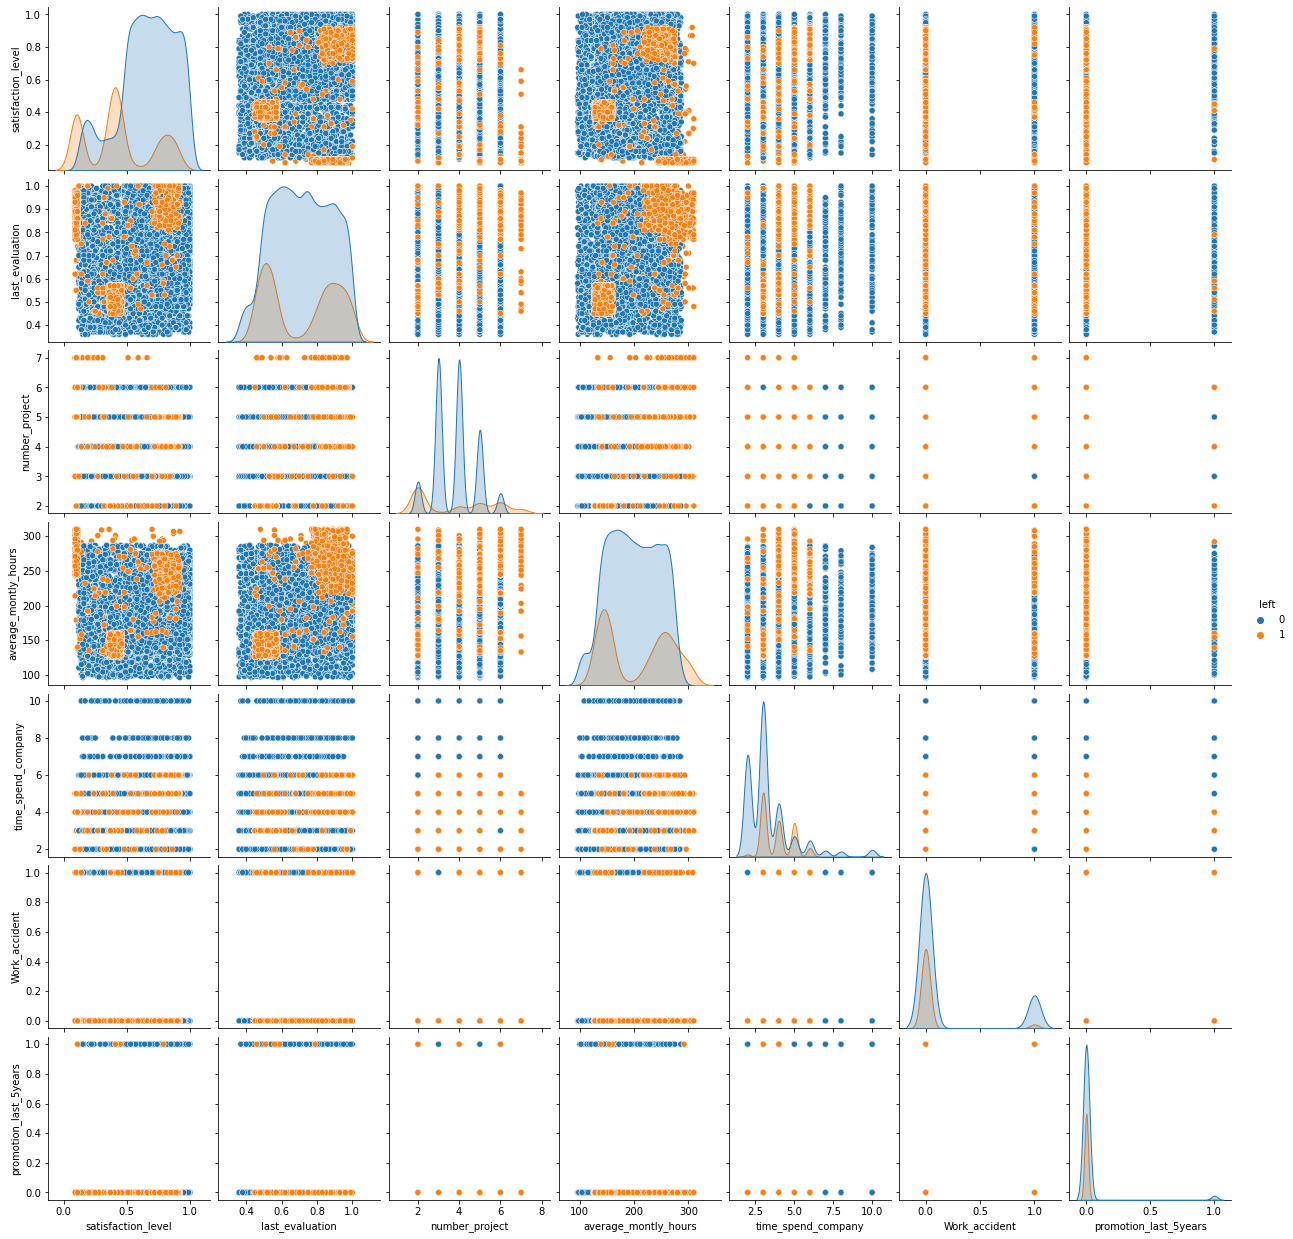

In [39]:
sns.pairplot(df, hue='left')